In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## TODO:
1. Specialize smooth nonlinear least squares solver

2. Better stopping conditions

3. Anneal out loss

4. Experiment with initialization at solution. 

In [5]:
dt = 0.2
noise_var = 0.
exp_data = LorenzExp
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = DataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 2500,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100
)
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=50.,
        fixed_data_weight=1.,
        max_inner_iterations=500,
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.e-08, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 50.0}
Warm Start


  0%|          | 0/2500 [00:00<?, ?it/s]

Iteration 0, loss = 6.501e+06, gradnorm = 3.322e+09, alpha = 5.0, improvement_ratio = 0.67
Iteration 1, loss = 6.172e+06, gradnorm = 3.807e+10, alpha = 3.941e+03, improvement_ratio = 0.05067
Iteration 2, loss = 2.348e+06, gradnorm = 3.474e+10, alpha = 100.0, improvement_ratio = 0.6196
Iteration 3, loss = 5.584e+05, gradnorm = 4.041e+10, alpha = 100.0, improvement_ratio = 0.7623
Iteration 4, loss = 1.092e+05, gradnorm = 1.531e+10, alpha = 83.33, improvement_ratio = 0.8049
Iteration 5, loss = 8.81e+03, gradnorm = 3.579e+09, alpha = 69.44, improvement_ratio = 0.9218
Iteration 100, loss = 41.64, gradnorm = 5.402e+05, alpha = 3.756, improvement_ratio = 0.8124
Iteration 200, loss = 1.877, gradnorm = 5.642e+05, alpha = 0.1176, improvement_ratio = 0.7929
Iteration 300, loss = 0.7572, gradnorm = 0.001473, alpha = 0.1238, improvement_ratio = 12.0
Iteration 400, loss = 0.7572, gradnorm = 0.0001504, alpha = 0.2825, improvement_ratio = 2.868
Iteration 500, loss = 0.7572, gradnorm = 7.665e-05, alpha

In [6]:
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


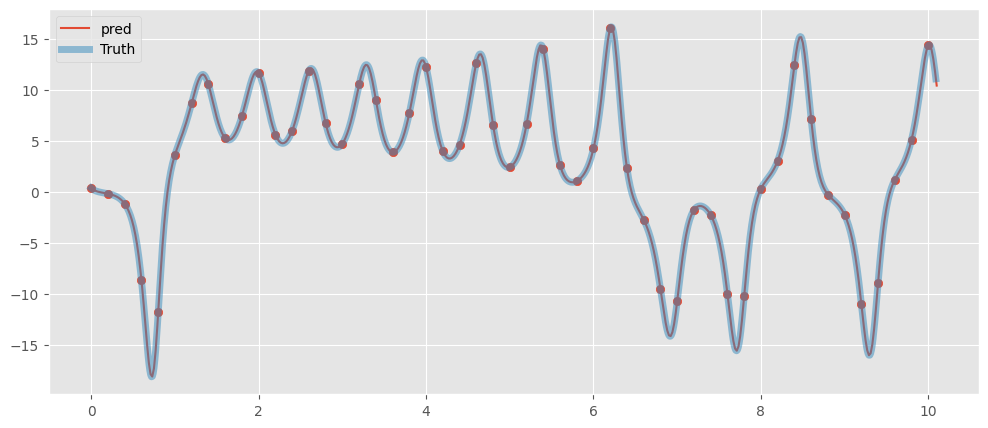

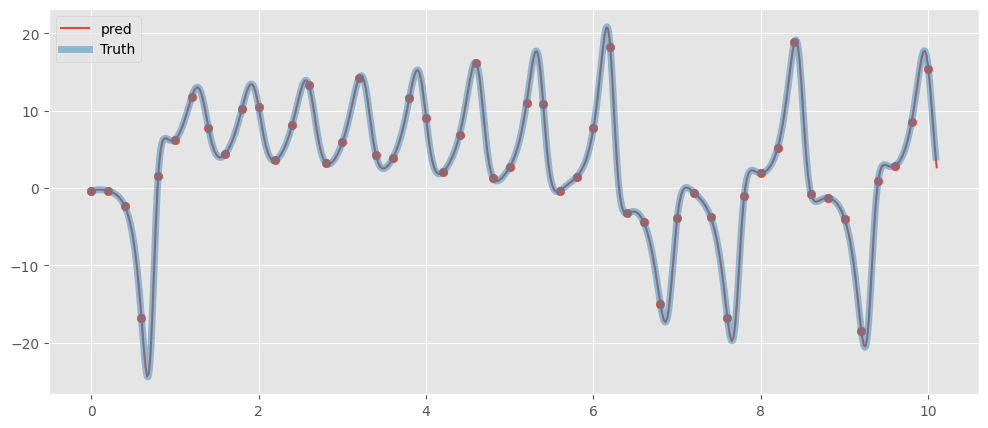

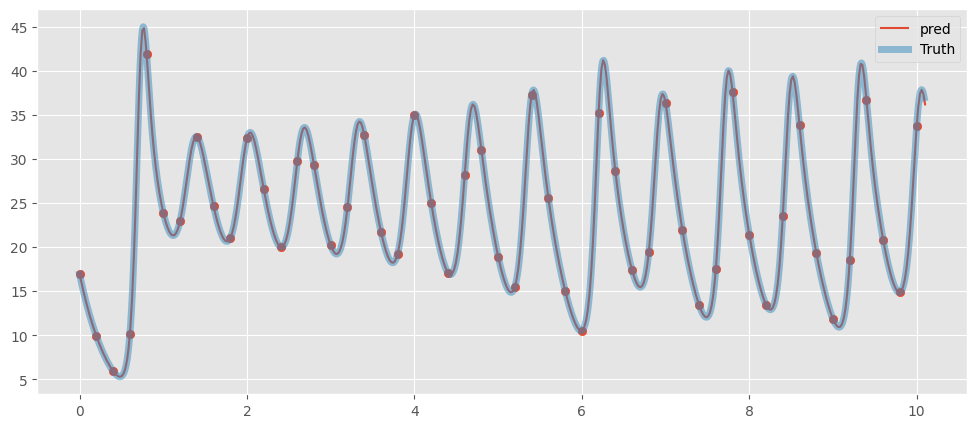

In [7]:
t_grid = jnp.linspace(0,10.1,500)
x_pred = model.predict_state(t_grid)

for i in range(3):
    plt.figure(figsize=(12,5))
    plt.scatter(expdata.t_train,expdata.x_train[:,i])
    plt.plot(t_grid,x_pred[:,i],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_true[:,i],lw = 5,alpha = 0.5,label = 'Truth')
    plt.legend()
    plt.show()

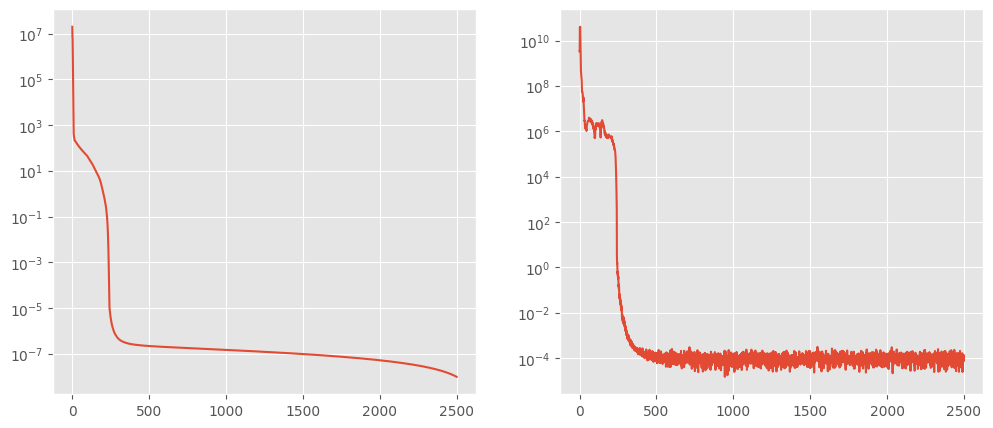

In [12]:
opt = model.opt_result[0]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(opt.loss_vals - opt.loss_vals[-1]+1e-8)
plt.yscale('log')
plt.subplot(1,2,2)
plt.plot(opt.gradnorm)
plt.yscale('log')
plt.show()

In [21]:
opt = model.opt_result[1]
opt.history['objval'][-1]

[Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826757, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826756, dtype=float64),
 Array(0.26826755, dtype=float64),
 Array(0.26826755, dtype=float64),
 Array(0.26826755, dtype=float64),
 Array(0.26826755, dtype=float64),
 Array(0.26826755, dtype=float64),
 Array(0.26826755, d